<div class="alert alert-success">
<h1>SETUP</h1>
</div>

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import re

## Setup input

In [2]:
def setup_input():

    colnames = ['user', 'user_id', 'tweet_id', 'text', 'hashtags',
                'tweet_date', 'user_start', 'followers_count',
                'friends', 'total_tweets', 'location', 'timezone',
                'user_tweet_id', 'sarcasm', 'sarcastic', 'irony',
                'ironic', 'happy', 'sad', 'seriously']
    
    dtypes_file = {'user':str, 'user_id':str, 'tweet_id':str, 'text':str, 'hashtags':str,
                'tweet_date':str, 'user_start':str, 'followers_count':str,
                'friends':str, 'total_tweets':str, 'location':str, 'timezone':str,
                'user_tweet_id':str, 'sarcasm':str, 'sarcastic':str, 'irony':str,
                'ironic':str, 'happy':str, 'sad':str, 'seriously':str}
    
    return colnames, dtypes_file

## Setup input

In [3]:
def setup_input2():
    
    colnames = ['user_tweet_id', 'user', 'user_id', 'tweet_id', 'text',
                'hashtags', 'tweet_date', 'user_start', 'followers_count',
                'friends', 'total_tweets', 'location', 'timezone',
                'sarcasm', 'sarcastic', 'irony', 'ironic', 'happy',
                'sad', 'seriously', 'num_ht']

    dtypes_file = {'user_tweet_id':str, 'user':str, 'user_id':str, 'tweet_id':str, 'text':str,
                   'hashtags':str, 'tweet_date':str, 'user_start':str, 'followers_count':str,
                   'friends':str, 'total_tweets':str, 'location':str, 'timezone':str,
                   'sarcasm':str, 'sarcastic':str, 'irony':str, 'ironic':str, 'happy':str,
                   'sad':str, 'seriously':str, 'num_ht': str}
    
    return colnames, dtypes_file

## Read in raw data

In [4]:
def get_input(path, num_files, hashtags):
    
    get_time('Start time: ')
    
    df = pd.DataFrame()
    num_file = 0
    
    # Set up for getting input
    colnames, dtypes_file = setup_input()

    # Calculate and print total number of folders and files
    _, files = get_num_folders_files(path)

    # iterate through files (containing tweets) in folder:
    for i in next(os.walk(path))[2]:

        if not i.startswith('hashtag'):
            continue

        num_file += 1
        
        if num_file >= num_files:
            break

        print_str = 'Importing file: ' + str(i) + ' (#' + str(num_file) + ' of ' + str(files) + '), time: '
        get_time(print_str)

        fullpath = os.path.join(str(path), str(i))
        
        df_temp = pd.read_csv(filepath_or_buffer = fullpath, sep = '\t',
                                  names=colnames, error_bad_lines=True,
                                  dtype=dtypes_file, encoding='utf-8')
        
        # clean file
        df_temp = clean_file(df_temp, hashtags)

        # if first csv in group, save as df:   
        if num_file == 1:
            df = df_temp
        else:
            df = df.append(df_temp)
                
    get_time('\nDone! End time: ')
    
    return df

## Read in dataframes

In [5]:
def read_in_dfs(df_list, hashtags):
    
    colnames, dtypes_file = setup_input2()
    
    dict_dfs = {}

    for i in range(0, len(df_list)):

        key = df_list[i]
        path = './hashtag_dfs/' + df_list[i] + '.txt'
        df = pd.read_csv(filepath_or_buffer = path, sep = '\t',
                         names = colnames, error_bad_lines = True,
                         dtype=dtypes_file, encoding = 'utf-8')
        
        df = clean_file(df, hashtags)
        
        value = df
        dict_dfs[key] = value 
        
        print('Dataframe ' + df_list[i] + ' loaded, length = {:,}.'.format(len(df)))

    return dict_dfs

## Clean file

In [6]:
def clean_file(df, hashtags):
    
    # Remove first row (duplicate with column names)
    df = df.iloc[1:]
    
    # Convert numeric columns to integers:
    pd.to_numeric(df['followers_count'], errors='coerce')
    pd.to_numeric(df['friends'], errors='coerce')
    pd.to_numeric(df['total_tweets'], errors='coerce')
    
    df['followers_count'] = df['followers_count'].astype(int)
    df['friends'] = df['friends'].astype(int)
    df['total_tweets'] = df['total_tweets'].astype(int)
    
    for ht in hashtags:
        pd.to_numeric(df[ht], errors ='coerce')
        df[ht] = df[ht].astype(int)
        
    return df

## Get number of folders and files

In [7]:
def get_num_folders_files(path):
    
    folders = 0
    files = 0

    for _, dirnames, filenames in os.walk(path):
        folders += len(dirnames)
        files += len(filenames)
    
    print('\nThere are {:,} total folders and {:,} total files.'.format(folders, files))
    
    return folders, files

## Get time

In [8]:
import datetime

def get_time(print_string):

    now = datetime.datetime.now()
    hour=int(now.hour)
    minute=int(now.minute)
    second=int(now.second)
    
    if(len(str(abs(minute)))) == 1:
        minute_str = "0" + str(minute)
    else:
        minute_str = str(minute)    
    
    if print_string != "":
        print(print_string + str(hour) + ":" + str(minute_str) + ":" + str(second))
    else:
        return hour, minute_str, second

<div class="alert alert-success">
<h1>DATA CLEANING</h1>
</div>

## Clean data
Drop rows with missing tweet text and report total number of tweets and users

In [9]:
def clean_data(df):
    
    # drop rows with missing tweet text
    df = df[~df.text.isnull()]
    
    # if index hasn't been set already
    if df.index.name == None:
        # remove duplicate tweets
        df = df.drop_duplicates(subset='user_tweet_id', keep = 'first')
        # set index to 'user_tweet_id' column
        df = df.set_index(['user_tweet_id'])
    
    # encode tweet text as utf-8
    col_text = df.columns.get_loc('text')
    for i in range(0,len(df)):
        df.iloc[i,col_text].encode('utf-8')

    return df

## Count total hashtags

In [10]:
def count_total_ht(df):
    
    df['num_ht'] = 0
    df['num_ht'][df['hashtags'] != '[]'] = df.hashtags.str.count(',')+1

    return df

## Count hashtags

In [11]:
def count_ht(df, perform_subset, ht):

    if perform_subset == True:
        
        df = df[df[ht] == 1]
    
    n_tweets = len(df)
    n_users = df.user.unique().size

    print('\nNumber of tweets with {} hashtag: {:,d}'.format(ht, n_tweets))
    print('Number of users with {} hashtag: {:,d}'.format(ht, n_users))

<div class="alert alert-success">
<h1>EXPLORATORY DATA ANALYSIS</h1>
</div>

## Get summary stats by hashtag

In [12]:
def get_stats(df, ht):
    
    df = df.drop_duplicates(subset = 'user', keep = 'first')
    
    print('\nSUMMARY STATS FOR "{}" HASHTAG'.format(ht.upper()))
    
    cols = ['followers_count', 'friends', 'total_tweets']
    
    print('\n\tTotal users: {:,}'.format(df.user.unique().size))
    
    for i in cols:
        
        col = df[i]
    
        print('\n\t{}'.format(i.upper()),
              '\n\tMean: {:,.1f}'.format(np.mean(col)),
              '\n\tSD: {:,.1f}'.format(np.std(col)),
              '\n\tRange: {:,.1f} to {:,.1f}'.format(col.min(), col.max()))

## Calculate number of hashtag uses
Given a dataframe and a hashtag as input, calculate and display the number of users that used the hashtag

In [13]:
def calc_num_ht_uses(df, ht):
    
    # calculate number of tweets each user made
    df_counts = df.groupby('user').sum() 
    
    print("\n\tNumber of users that used '" + str(ht) + "' hashtag X times:")

    for i in range(1,6,1):
        ct = len(df_counts[(df_counts[ht] == i)])
        print('\tX = ' + str(i) + ' time(s): {:,}'.format(ct))

    print("\n\tNumber of users that used '" + str(ht) + "' hashtag more than X times:")

    ct = len(df_counts[(df_counts[ht] > 5)])
    print('\tX > ' + str(5) + ' times: {:,}'.format(ct))

## Make histogram

In [14]:
def make_hist(df, col, num_grps, xlabel, ylabel, title, filename):
    
    # convert column to string
    df[col] = df[col].astype(str)

    # remove missing values
    df = df[df[col] != 'nan']

    df[col].value_counts()[0:num_grps].plot(kind = 'bar')
    plt.xlabel(xlabel)
    plt.xticks(rotation=0)
    plt.ylabel(ylabel)
    plt.title(title + '\n')
    plt.xticks(rotation=90)
    
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]    
    fig_size[0] = 5
    fig_size[1] = 3
    plt.rcParams["figure.figsize"] = fig_size
    
    if filename != '':
        filepath = './graphs/' + filename + '.png'
        plt.savefig(filepath, bbox_inches='tight')

<div class="alert alert-success">
<h1>TEST-TRAIN SPLIT</h1>
</div>

In [42]:
from sklearn.cross_validation import train_test_split

def create_train_test(df, filename_base):
    
    tt_exist = False

    # set file names
    mask_file = './training_test_sets/mask_' + filename_base + '.txt'
    
    """If training and test sets exist, load them; otherwise, create them"""
    if os.path.isfile(mask_file):
        
        tt_exist = True
        
        print('\nTraining and test set files already exist, opening now.')
        
        print('Reading in mask from ' + mask_file)
        mask = np.loadtxt(mask_file, delimiter = '\t')
        print('\nLength of mask: {:,}'.format(len(mask)))
        #mask = mask[1:] # remove header row
        
        mask = mask.astype(bool)
        
        train_data = df[~mask]
        test_data = df[mask]

    else: 

        print('\nTraining and test set files do not exist, generating now.')

        # create training and test sets
        # in below, itest is an array containing the row numbers of the test set (which is 30% of the overall dataset)
        _, itest = train_test_split(range(df.shape[0]), train_size = 0.7)
        mask = np.zeros(df.shape[0], dtype=np.bool)
        mask[itest] = True

        train_data = df[~mask]
        test_data = df[mask]
            
        print('Saving mask to ' + mask_file)
        np.savetxt(fname = mask_file, X = mask, delimiter = '\t')
        
    print('Length of test: {:,}'.format(len(test_data)))
    print('Length of train: {:,}'.format(len(train_data)))
    print('Length of test + train: {:,}'.format(len(test_data) + len(train_data)))

    return train_data, test_data, mask

<div class="alert alert-success">
<h1>MODELING</h1>
</div>

## Determine most frequent words

In [108]:
def freq_words(num_words, cv, X, top):

    words = np.array(cv.get_feature_names())

    # calculate word frequencies
    freq = np.asarray(X.sum(axis=0)).ravel()

    # sort rows by frequencies (low to high) and return indices:
    ind = np.argsort(freq)
    
    if top == True:
        # freq_words = words with highest probability
        # below, freq_words represents N words from end (highest freqs)
        freq_words = words[ind[-num_words:]]
        freq_num = freq[ind[-num_words:]]
        
        print('Most frequent words\n')
        for w, p in zip(freq_words, freq_num):
            print('{:>10,.2f}'.format(p), '{:>10}'.format(w))
    else:
        # freq_words = words with highest probability
        freq_words = words[ind[:num_words]]
        freq_num = freq[ind[:num_words]]
        print('Least frequent words\n')
        for w, p in zip(freq_words, freq_num):
            print('{:>10,.2f}'.format(p), '{:>10}'.format(w))    
    
    print('\nTotal # of words in vocabulary: {:,}'.format(len(words)))

## Determine most predictive words

In [17]:
def predictive_words(num_words, cv, clf, Xtest):

    words = np.array(cv.get_feature_names())
    
    # create identity matrix (each row has exactly 1 feature):
    x = np.eye(Xtest.shape[1]) 

    # use trained classifier to make predictions on this matrix:
    probs = clf.predict_log_proba(x)[:, 0] 

    # sort rows by predicted probabilities and return indices:
    ind = np.argsort(probs) 

    # good_words = words with highest probability
    good_words = words[ind[:num_words]]

    # bad_words = words with lowest probability
    bad_words = words[ind[-num_words:]]

    good_prob = probs[ind[:num_words]]
    bad_prob = probs[ind[-num_words:]]

    print('\nMost predictive words')
    print('\tP(sarcasm | word)')
    for w, p in zip(good_words, good_prob):
        print('{:>10}'.format(w), '{:>10.2f}'.format(1 - np.exp(p)))

    print('\nLeast predictive words')
    print('\tP(sarcasm | word)')
    for w, p in zip(bad_words, bad_prob):
        print('{:>10}'.format(w), '{:>10.2f}'.format(1 - np.exp(p))) 

## Model evaluation

In [18]:
from sklearn import metrics

def model_eval(clf, Xtrain, Xtest, ytrain, ytest):

    ypred_test = clf.predict(Xtest)
    ypred_train = clf.predict(Xtrain)
    ypred_proba = clf.predict_proba(Xtest)

    # accuracy
    acc_train = round(100*metrics.accuracy_score(ypred_train, ytrain),2)
    print('\nAccuracy for training set = {:.2f}%'.format(acc_train))

    acc_test = round(100*metrics.accuracy_score(ypred_test, ytest),2)
    print('Accuracy for test set = {:.2f}%'.format(acc_test))

    # cohen's kappa
    cohenk = metrics.cohen_kappa_score(ytest, ypred_test)
    print('Cohen\'s Kappa = {:.2f}'.format(cohenk))
    
    # precision (ability of classifier not to label as positive a sample that is negative)
    precision = metrics.precision_score(ytest, ypred_test)
    print('Precision = {:.2f}'.format(precision))

    # AUC
    auc = metrics.roc_auc_score(ytest, ypred_proba[:,1])
    print('AUC = {:.2f}'.format(auc))
    
    # create confusion matrix
    classes = np.unique(ytest)

    cnf_matrix = metrics.confusion_matrix(ytest, ypred_test)
    np.set_printoptions(precision=2)

    tp = float(cnf_matrix[0][0])/np.sum(cnf_matrix[0])
    tn = float(cnf_matrix[1][1])/np.sum(cnf_matrix[1])
    
    print('True positive rate = {:.2f}'.format(tp))
    print('True negative rate = {:.2f}'.format(tn))

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes, False)
    plt.show()

## Create confusion matrix

In [19]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes, normalize, cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Confusion matrix, with normalization'
    else:
        title = 'Confusion matrix, without normalization'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Cross-validation

In [20]:
from sklearn.model_selection import KFold

def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    
    # split data into train/test groups, 5 times
    for train, test in KFold(nfold, shuffle=True).split(X, y):

        # fit the classifier, passed is as clf
        clf.fit(X[train], y[train]) 

        # evaluate score function on held-out data
        result += scorefunc(clf, X[test], y[test])
        
    # average score
    return result / nfold

In [21]:
from sklearn.metrics import roc_auc_score

def auc(clf, x, y):
    
    pred = clf.predict_proba(x) 
    
    return roc_auc_score(y, pred[:,1])

In [22]:
from sklearn.metrics import cohen_kappa_score

def cohenk(clf, x, y):
    
    pred = clf.predict(x)
    
    return cohen_kappa_score(y, pred)

In [23]:
def log_likelihood(clf, x, y):
    
    pred = clf.predict_log_proba(x)
    sarcasm = y == 1
    not_sarcasm = ~sarcasm
    
    # add together:
    # 1. the log probability of sarcasm samples being labeled 1 (sarcasm)
    # 2. the log probability of non-sarcasm samples being labeled 0 (non-sarcasm)
    return pred[sarcasm, 1].sum() + pred[not_sarcasm, 0].sum()

In [96]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

def perform_cv_NB(df, mask, alphas, min_dfs, max_dfs, ngrams, score_func, vect_str):    
    
    best_params = {}
    numerator = 0
    denominator = len(alphas)
    
    #Find the best value for alpha and min_df, and the best classifier
    max_score=-np.inf
    
    #mask = mask.astype(int)
    
    for alpha in alphas:
        numerator += 1
        for min_df in min_dfs:
            for max_df in max_dfs:
                for ngram in ngrams:
                    
                    if vect_str == 'count': 
                        vectorizer = CountVectorizer(min_df=min_df, max_df=max_df, stop_words = 'english',ngram_range=ngram)       
                    elif vect_str == 'tfidf':
                        vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, stop_words = 'english',ngram_range=ngram)
                    else:
                        print('Vectorizer not found.')
                        break

                    Xthis, ythis, _ = make_xy(df, vectorizer)

                    if Xthis == None:
                        print('After pruning, no terms remain; alpha: {}, min_df: {}, max_df: {}'.
                              format(alpha, min_df, max_df))

                        continue
                    else:
                        # only use training data for cross-validation
                        Xtrainthis = Xthis[~mask]
                        ytrainthis = ythis[~mask]

                        clf = MultinomialNB(alpha = alpha)

                        score = cv_score(clf, Xtrainthis, ytrainthis, score_func)

                        if score > max_score:
                            max_score = score
                            best_params['score'] = score
                            best_params['alpha'] = alpha
                            best_params['min_df'] = min_df
                            best_params['max_df'] = max_df
                            best_params['ngram'] = ngram  
                            
        print('Progress: {:.0f}%'.format(100*(numerator/denominator)))

    print('Score: {:.3}, alpha: {}, min_df: {}, max_df: {}, ngram: {}'.
          format(best_params['score'], best_params['alpha'], best_params['min_df'],
                 best_params['max_df'], best_params['ngram']))
    
    return best_params, clf

In [88]:
def perform_cv_RF(df, mask, min_dfs, max_dfs, ngrams, score_func, n_estimators, min_samples_split):
    
    best_params = {}
    numerator = 0
    denominator = len(min_dfs)
    
    #Find the best value for alpha and min_df, and the best classifier
    max_score=-np.inf
    
    for min_df in min_dfs:
        numerator += 1
        print('Current min_df = ' + str(min_df))
        for max_df in max_dfs:
            for ngram in ngrams:

                vectorizer = CountVectorizer(min_df=min_df, max_df=max_df, stop_words = 'english',ngram_range=ngram)       
                Xthis, ythis, _ = make_xy(df, vectorizer)

                if Xthis == None:
                    print('After pruning, no terms remain; alpha: {}, min_df: {}, max_df: {}'.
                          format(alpha, min_df, max_df))

                    continue
                else:
                    # only use training data for cross-validation
                    Xtrainthis = Xthis[~mask]
                    ytrainthis = ythis[~mask]

                    for n_est in n_estimators:
                        for min_split in min_samples_split:
                        
                            clf = RandomForestClassifier(n_estimators=n_est, min_samples_split=min_split)

                            score = cv_score(clf, Xtrainthis, ytrainthis, score_func)

                            if score > max_score:
                                max_score = score
                                best_params['score'] = score
                                best_params['min_df'] = min_df
                                best_params['max_df'] = max_df
                                best_params['ngram'] = ngram      
                                best_params['n_est'] = n_est
                                best_params['min_samples_split'] = min_split
        print('Progress: {:.0f}%'.format(100*(numerator/denominator)))

    print('Score: {:.3}, min_df: {}, max_df: {}, ngram: {}, n_estimaors: {}, min_samples_split: {}'.
          format(best_params['score'], nest_params['min_df'], best_params['max_df'],
                 best_params['ngram'], best_params['n_est'], best_params['min_samples_split']))

    return best_params, clf

## Make term-document matrix

In [25]:
def make_xy(df, vectorizer):
    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    
    # call `fit` to build the vocabulary
    try:
        vectorizer.fit(df['text'])

        # call `transform` to convert text to a bag of words
        x = vectorizer.transform(df['text'])

        X = x.tocsc()  # some versions of sklearn return COO format

        # CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
        # convert back to a "normal" numpy array
        #X = X.toarray()

        # convert sarcasm column to integers
        y = (df['sarcasm'] == 1).values.astype(np.int) 

    except ValueError:
    
        X = None
        y = None
        vectorizer = None

    return X, y, vectorizer

<div class="alert alert-success">
<h1>MAIN CODE</h1>
</div>

In [26]:
input_path = './hashtag_tweets/'

num_files = np.inf
hashtags = ['sarcasm','sarcastic','irony','ironic','happy','sad','seriously']

"""Check whether hashtag dataframes already exist"""
df_list = ['tweets_all', 'tweets_sarcasm', 'tweets_sad', 'tweets_happy', 'tweets_seriously']

for df in df_list:
    filepath = './hashtag_dfs/' + df + '.txt'
    if not os.path.isfile(filepath):        
        dfs_exist = False
    else:
        dfs_exist = True

if dfs_exist == False:
    """if hashtag dataframes DON'T already exist, get input and create them"""
    
    print('Dataframes do not exist, creating now.')
    tweets_all = get_input(input_path, num_files, hashtags)
else:
    """if hashtag dataframes DO already exist, load them"""

    print('Dataframes already exist, loading now.')
    
    dict_dfs = read_in_dfs(df_list, hashtags)
    tweets_all = dict_dfs['tweets_all']    
    tweets_sarcasm = dict_dfs['tweets_sarcasm']    
    tweets_happy = dict_dfs['tweets_happy']    
    tweets_sad = dict_dfs['tweets_sad']    
    tweets_seriously = dict_dfs['tweets_seriously']

Dataframes already exist, loading now.


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

Dataframe tweets_all loaded, length = 95,860.
Dataframe tweets_sarcasm loaded, length = 30,910.
Dataframe tweets_sad loaded, length = 40,861.
Dataframe tweets_happy loaded, length = 12,639.
Dataframe tweets_seriously loaded, length = 11,450.


In [27]:
"""If dataframes do NOT exist, create them and save them as text files"""
if dfs_exist == False:
    
    # subset data to tweets with only one hashtag
    tweets_all = count_total_ht(tweets_all)
    tweets_all = tweets_all[tweets_all.num_ht == 1]
    
    # remove duplicate tweets & drop rows with no tweet text
    tweets_all = clean_data(tweets_all)
    
    # create subset dataframes
    tweets_sarcasm = tweets_all[tweets_all.sarcasm == 1]
    tweets_happy = tweets_all[tweets_all.happy == 1]
    tweets_sad = tweets_all[tweets_all.sad == 1]
    tweets_seriously = tweets_all[tweets_all.seriously == 1]
    
    # only include tweets with hashtag at end 
    pattern = r'\bsarcasm\b$'
    tweets_sarcasm = tweets_sarcasm[(tweets_sarcasm['text'].str.contains(pattern, case=False, na=False, regex=True))]

    pattern = r'\bhappy\b$'
    tweets_happy = tweets_happy[(tweets_happy['text'].str.contains(pattern, case=False, na=False, regex=True))]

    pattern = r'\bsad\b$'
    tweets_sad = tweets_sad[(tweets_sad['text'].str.contains(pattern, case=False, na=False, regex=True))]

    pattern = r'\bseriously\b$'
    tweets_seriously = tweets_seriously[(tweets_seriously['text'].str.contains(pattern, case=False, na=False, regex=True))]
    
    # remove hashtag from tweet text
    tweets_sarcasm['text'] = tweets_sarcasm['text'].str.replace('#sarcasm', '', case=False)
    tweets_happy['text'] = tweets_happy['text'].str.replace('#happy', '', case=False)
    tweets_sad['text'] = tweets_sad['text'].str.replace('#sad', '', case=False)
    tweets_seriously['text'] = tweets_seriously['text'].str.replace('#seriously', '', case=False)
    
    # remove '(quote)' from tweet text
    tweets_sarcasm['text'] = tweets_sarcasm['text'].str.replace('(quote)', '', case=False)
    tweets_happy['text'] = tweets_happy['text'].str.replace('(quote)', '', case=False)
    tweets_sad['text'] = tweets_sad['text'].str.replace('(quote)', '', case=False)
    tweets_seriously['text'] = tweets_seriously['text'].str.replace('(quote)', '', case=False)
    
    # remove URLs from tweet text
    pattern1 = r'http\S+'
    pattern2 = r'www\S+'
    tweets_sarcasm['text'] = tweets_sarcasm['text'] .str.replace(pattern1, '')
    tweets_sarcasm['text'] = tweets_sarcasm['text'] .str.replace(pattern2, '')
    tweets_happy['text'] = tweets_happy['text'] .str.replace(pattern1, '')
    tweets_happy['text'] = tweets_happy['text'] .str.replace(pattern2, '')
    tweets_sad['text'] = tweets_sad['text'] .str.replace(pattern1, '')
    tweets_sad['text'] = tweets_sad['text'] .str.replace(pattern2, '')
    tweets_seriously['text'] = tweets_seriously['text'] .str.replace(pattern1, '')
    tweets_seriously['text'] = tweets_seriously['text'] .str.replace(pattern2, '')

    # create new dataframe containing all tweets for above hashtags only
    tweets_all = pd.concat([tweets_sarcasm, tweets_happy, tweets_sad, tweets_seriously])
    
    # save dataframes
    filename = 'tweets_all'
    filepath = './hashtag_dfs/' + filename + '.txt'

    # Save df if file doesn't exist
    tweets_all.to_csv(filepath, sep = '\t', index = True, header = True)

    filename = 'tweets_sarcasm'
    filepath = './hashtag_dfs/' + filename + '.txt'

    # Save df if file doesn't exist
    tweets_sarcasm.to_csv(filepath, sep = '\t', index = True, header = True)

    filename = 'tweets_happy'
    filepath = './hashtag_dfs/' + filename + '.txt'

    # Save df if file doesn't exist
    tweets_happy.to_csv(filepath, sep = '\t', index = True, header = True)

    filename = 'tweets_sad'
    filepath = './hashtag_dfs/' + filename + '.txt'

    # Save df if file doesn't exist
    tweets_sad.to_csv(filepath, sep = '\t', index = True, header = True)

    filename = 'tweets_seriously'
    filepath = './hashtag_dfs/' + filename + '.txt'

    # Save df if file doesn't exist
    tweets_seriously.to_csv(filepath, sep = '\t', index = True, header = True)

### Count number of tweets and users

In [28]:
count_ht(tweets_sarcasm, False, 'sarcasm')
count_ht(tweets_happy, False, 'happy')
count_ht(tweets_sad, False, 'sad')
count_ht(tweets_seriously, False, 'seriously')


Number of tweets with sarcasm hashtag: 30,910
Number of users with sarcasm hashtag: 23,509

Number of tweets with happy hashtag: 12,639
Number of users with happy hashtag: 10,149

Number of tweets with sad hashtag: 40,861
Number of users with sad hashtag: 26,456

Number of tweets with seriously hashtag: 11,450
Number of users with seriously hashtag: 9,033


### Get stats by hashtag

In [29]:
get_stats(tweets_sarcasm, 'sarcasm')
calc_num_ht_uses(tweets_sarcasm, 'sarcasm')

get_stats(tweets_happy, 'happy')
calc_num_ht_uses(tweets_happy, 'happy')

get_stats(tweets_sad, 'sad')
calc_num_ht_uses(tweets_sad, 'sad')

get_stats(tweets_seriously, 'seriously')
calc_num_ht_uses(tweets_seriously, 'seriously')


SUMMARY STATS FOR "SARCASM" HASHTAG

	Total users: 23,509

	FOLLOWERS_COUNT 
	Mean: 868.2 
	SD: 35,070.6 
	Range: 0.0 to 5,192,273.0

	FRIENDS 
	Mean: 629.2 
	SD: 1,671.0 
	Range: 0.0 to 176,631.0

	TOTAL_TWEETS 
	Mean: 4,295.6 
	SD: 8,341.5 
	Range: 2.0 to 446,022.0

	Number of users that used 'sarcasm' hashtag X times:
	X = 1 time(s): 19,213
	X = 2 time(s): 2,883
	X = 3 time(s): 773
	X = 4 time(s): 289
	X = 5 time(s): 159

	Number of users that used 'sarcasm' hashtag more than X times:
	X > 5 times: 192

SUMMARY STATS FOR "HAPPY" HASHTAG

	Total users: 10,149

	FOLLOWERS_COUNT 
	Mean: 812.5 
	SD: 10,361.0 
	Range: 0.0 to 753,605.0

	FRIENDS 
	Mean: 693.7 
	SD: 2,478.5 
	Range: 0.0 to 223,235.0

	TOTAL_TWEETS 
	Mean: 3,851.3 
	SD: 5,809.7 
	Range: 1.0 to 175,701.0

	Number of users that used 'happy' hashtag X times:
	X = 1 time(s): 8,559
	X = 2 time(s): 1,111
	X = 3 time(s): 287
	X = 4 time(s): 103
	X = 5 time(s): 41

	Number of users that used 'happy' hashtag more than X times:
	X >

### Top user locations by hashtag

In [30]:
print('\nSarcasm Hashtag:\n{}'.format(tweets_sarcasm['location'].value_counts()[0:5]))
print('\nHappy Hashtag:\n{}'.format(tweets_happy['location'].value_counts()[0:5]))
print('\nSad Hashtag:\n{}'.format(tweets_sad['location'].value_counts()[0:5]))
print('\nSeriously Hashtag:\n{}'.format(tweets_seriously['location'].value_counts()[0:5]))


Sarcasm Hashtag:
New York, NY       255
Los Angeles, CA    250
Chicago, IL        245
United States      212
Seattle, WA        172
Name: location, dtype: int64

Happy Hashtag:
Los Angeles, CA    141
New York, NY       132
London             124
Chicago, IL        119
Washington, DC      95
Name: location, dtype: int64

Sad Hashtag:
United States      624
Los Angeles, CA    373
New York, NY       352
Chicago, IL        311
Washington, DC     274
Name: location, dtype: int64

Seriously Hashtag:
Seriously?         171
Chicago, IL        126
Washington, DC     116
New York, NY       113
Los Angeles, CA    112
Name: location, dtype: int64


### Top timezones by hashtag

In [31]:
print('\nSarcasm Hashtag:\n{}'.format(tweets_sarcasm['timezone'].value_counts()[0:5]))
print('\nHappy Hashtag:\n{}'.format(tweets_happy['timezone'].value_counts()[0:5]))
print('\nSad Hashtag:\n{}'.format(tweets_sad['timezone'].value_counts()[0:5]))
print('\nSeriously Hashtag:\n{}'.format(tweets_seriously['timezone'].value_counts()[0:5]))


Sarcasm Hashtag:
Eastern Time (US & Canada)    7334
Central Time (US & Canada)    5323
Pacific Time (US & Canada)    3552
Quito                         1210
London                        1088
Name: timezone, dtype: int64

Happy Hashtag:
Eastern Time (US & Canada)    2631
Central Time (US & Canada)    1964
Pacific Time (US & Canada)    1427
London                         779
Quito                          662
Name: timezone, dtype: int64

Sad Hashtag:
Eastern Time (US & Canada)    8679
Pacific Time (US & Canada)    5107
Central Time (US & Canada)    4978
Quito                         1516
Atlantic Time (Canada)        1229
Name: timezone, dtype: int64

Seriously Hashtag:
Eastern Time (US & Canada)    2809
Central Time (US & Canada)    2329
Pacific Time (US & Canada)    1190
Quito                          678
Atlantic Time (Canada)         475
Name: timezone, dtype: int64


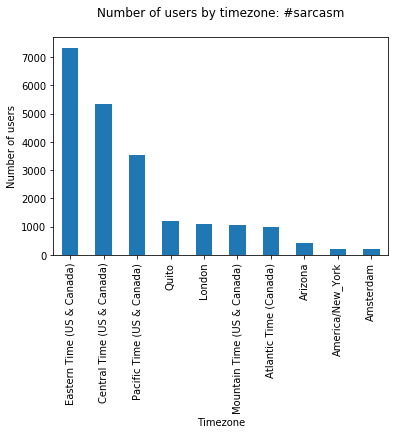

In [32]:
title = 'Number of users by timezone: #sarcasm'
xlabel = 'Timezone'
ylabel = 'Number of users'
filename = 'timezones_sarcasm'
make_hist(tweets_sarcasm, 'timezone', 10, xlabel, ylabel, title, filename)

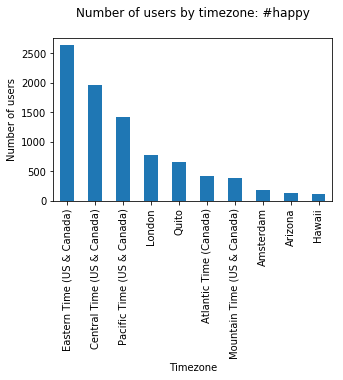

In [33]:
title = 'Number of users by timezone: #happy'
xlabel = 'Timezone'
ylabel = 'Number of users'
filename = 'timezones_happy'
make_hist(tweets_happy, 'timezone', 10, xlabel, ylabel, title, filename)

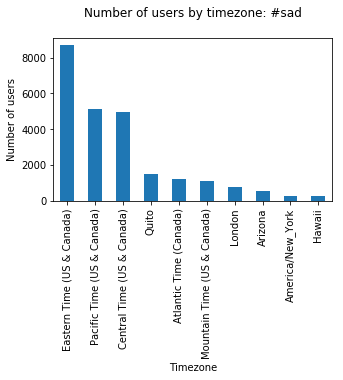

In [34]:
title = 'Number of users by timezone: #sad'
xlabel = 'Timezone'
ylabel = 'Number of users'
filename = 'timezones_sad'
make_hist(tweets_sad, 'timezone', 10, xlabel, ylabel, title, filename)

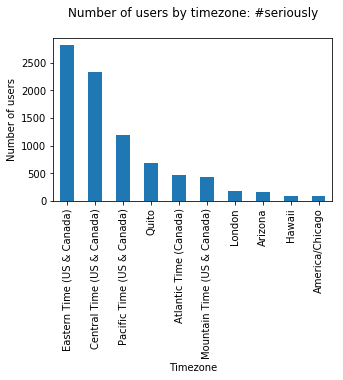

In [35]:
title = 'Number of users by timezone: #seriously'
xlabel = 'Timezone'
ylabel = 'Number of users'
filename = 'timezones_seriously'
make_hist(tweets_seriously, 'timezone', 10, xlabel, ylabel, title, filename)

### Create/load subset dataframe
Subset dataframe contains 50% sarcastic tweets and 50% other tweets (17% each of sad, happy, and seriously tweets)

In [36]:
hashtags = ['sarcasm', 'happy', 'sad', 'seriously']
filepath = './hashtag_dfs/tweets_all_sub.txt'

"""Check whether subset hashtag dataframe already exists"""

if not os.path.isfile(filepath):
    
    """if hashtag dataframe DOESN'T already exist, create it"""
    
    print('Dataframe does not exist, creating now.')
    
    onethird_sarcasm = int(sum(tweets_all['sarcasm'])/3)

    # randomly sample rows from happy, sad, and seriously tweets
    tweets_happy_sub = tweets_happy.sample(n = onethird_sarcasm)
    tweets_sad_sub = tweets_sad.sample(n = onethird_sarcasm)
    tweets_seriously_sub = tweets_seriously.sample(n = onethird_sarcasm)

    # combine the subset dataframes
    tweets_all_sub = pd.concat([tweets_sarcasm,
                             tweets_happy_sub,
                             tweets_sad_sub,
                             tweets_seriously_sub])

    # remove blanks
    tweets_all_sub = tweets_all_sub[pd.notnull(tweets_all_sub['text'])]
    
    # save file
    tweets_all_sub.to_csv(filepath, sep = '\t', index = True, header = True)
    
else:
    """if hashtag dataframe DOES already exist, load it"""
    
    print('Dataframe already exists, loading now.')
    
    colnames, dtypes_file = setup_input2()
    
    tweets_all_sub = pd.read_csv(filepath_or_buffer = filepath, sep = '\t',
                              names = colnames, error_bad_lines = True,
                              dtype=dtypes_file, encoding = 'utf-8')

    # clean file
    tweets_all_sub = clean_file(tweets_all_sub, hashtags)

sar_n = sum(tweets_all_sub['sarcasm'])
sad_n = sum(tweets_all_sub['sad'])
ser_n = sum(tweets_all_sub['seriously'])
hap_n = sum(tweets_all_sub['happy'])
total_n = len(tweets_all_sub)

print('Total number of tweets: {:,}'.format(total_n))
print('Number of sarcastic tweets: {:,} ({:.2f}%)'.format(sar_n, 100*(sar_n/total_n)))
print('Number of happy tweets: {:,} ({:.2f}%)'.format(hap_n, 100*(hap_n/total_n)))
print('Number of sad tweets: {:,} ({:.2f}%)'.format(sad_n, 100*(sad_n/total_n)))
print('Number of seriously tweets: {:,} ({:.2f}%)'.format(ser_n, 100*(ser_n/total_n)))

Dataframe already exists, loading now.


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

Total number of tweets: 61,289
Number of sarcastic tweets: 30,728 (50.14%)
Number of happy tweets: 10,042 (16.38%)
Number of sad tweets: 10,256 (16.73%)
Number of seriously tweets: 10,263 (16.75%)


### Create test and training data

In [43]:
filename_base = 'sarcasm_happy_sad_seriously'
strat = True
train, test, mask = create_train_test(tweets_all_sub, filename_base)

prop_sarc = sum(train['sarcasm'])/len(train)
print('\nPercent of sarcasm in training set: {:.2f}%'.format(prop_sarc*100))

prop_sarc = sum(test['sarcasm'])/len(test)
print('Percent of sarcasm in test set: {:.2f}%'.format(prop_sarc*100))


Training and test set files already exist, opening now.
Reading in mask from ./training_test_sets/mask_sarcasm_happy_sad_seriously.txt

Length of mask: 61,289
Length of test: 18,387
Length of train: 42,902
Length of test + train: 61,289

Percent of sarcasm in training set: 50.06%
Percent of sarcasm in test set: 50.31%


### Perform cross-validation

#### Naive Bayes with AUC as scoring function & using CountVectorizer

In [98]:
alphas = [1, 5, 10, 15, 20]
min_dfs = [1, 2, 5, 10, 15]
max_dfs = [.6, .7, .8, .9, 1.0]
ngrams = [(1,1), (2,2)]
score_func = auc # options: log_likelihood, cohenk, auc
vect_str = 'count'

print('Results for Naive Bayes model using CountVectorizer with AUC as scoring function:\n')
best_params_NB_auc_count, clf_NB_auc_count = perform_cv_NB(tweets_all_sub, mask, alphas, min_dfs, max_dfs, ngrams, score_func, vect_str)

Results for Naive Bayes model using CountVectorizer with AUC as scoring function:
Progress: 20%
Progress: 40%
Progress: 60%
Progress: 80%
Progress: 100%
Score: 0.775, alpha: 5, min_df: 2, max_df: 0.9, ngram: (1, 1)


#### Naive Bayes with AUC as scoring function & using TF-IDF Vectorizer

In [99]:
alphas = [1, 5, 10, 15, 20]
min_dfs = [1, 2, 5, 10, 15]
max_dfs = [.6, .7, .8, .9, 1.0]
ngrams = [(1,1), (2,2)]
score_func = auc # options: log_likelihood, cohenk, auc
vect_str = 'tfidf'

print('Results for Naive Bayes model using TfidfVectorizer with AUC as scoring function:\n')
best_params_NB_auc_tfidf, clf_NB_auc_tfidf = perform_cv_NB(tweets_all_sub, mask, alphas, min_dfs, max_dfs, ngrams, score_func, vect_str)

Results for Naive Bayes model using TfidfVectorizer with AUC as scoring function:
Progress: 20%
Progress: 40%
Progress: 60%
Progress: 80%
Progress: 100%
Score: 0.777, alpha: 10, min_df: 2, max_df: 1.0, ngram: (1, 1)


#### Naive Bayes with log likelihood as scoring function & using CountVectorizer

In [100]:
alphas = [1, 5, 10, 15, 20]
min_dfs = [1, 2, 5, 10, 15]
max_dfs = [.6, .7, .8, .9, 1.0]
ngrams = [(1,1), (2,2)]
score_func = log_likelihood # options: log_likelihood, cohenk, auc
vect_str = 'count'

print('Results for Naive Bayes model using CountVectorizer with Log-Likelihood as scoring function:\n')
best_params_NB_ll_count, clf_NB_ll_count = perform_cv_NB(tweets_all_sub, mask, alphas, min_dfs, max_dfs, ngrams, score_func, vect_str)

Results for Naive Bayes model using CountVectorizer with Log-Likelihood as scoring function:

Progress: 20%
Progress: 40%
Progress: 60%
Progress: 80%
Progress: 100%
Score: -4.91e+03, alpha: 10, min_df: 2, max_df: 0.7, ngram: (1, 1)


#### Naive Bayes with log likelihood as scoring function & using TF-IDF Vectorizer

In [101]:
alphas = [1, 5, 10, 15, 20]
min_dfs = [1, 2, 5, 10, 15]
max_dfs = [.6, .7, .8, .9, 1.0]
ngrams = [(1,1), (2,2)]
score_func = log_likelihood # options: log_likelihood, cohenk, auc
vect_str = 'tfidf'

print('Results for Naive Bayes model using TfidfVectorizer with Log-Likelihood as scoring function:\n')
best_params_NB_ll_tfidf, clf_NB_ll_tfidft = perform_cv_NB(tweets_all_sub, mask, alphas, min_dfs, max_dfs, ngrams, score_func, vect_str)

Results for Naive Bayes model using TfidfVectorizer with Log-Likelihood as scoring function:

Progress: 20%
Progress: 40%
Progress: 60%
Progress: 80%
Progress: 100%
Score: -5.08e+03, alpha: 1, min_df: 2, max_df: 0.7, ngram: (1, 1)


#### Random Forest with AUC as scoring function

In [90]:
min_dfs = [1, 2]
max_dfs = [.8, .9, 1.0]
ngrams = [(1,1), (2,2)]
n_estimators = [1, 5]
min_samples_split = [2, 3]
score_func = auc # options: log_likelihood, cohenk, auc

best_params_RF_auc, clf_RF_auc = perform_cv_RF(tweets_all_sub, mask, min_dfs, max_dfs, ngrams, score_func, n_estimators, min_samples_split)

Current min_df = 1


KeyboardInterrupt: 

### Model evaluation

MODEL EVALUATION FOR NAIVE BAYES (AUC) WITH COUNT VECTORIZER
Most frequent words

  2,097.00       know
  2,217.00 realdonaldtrump
  2,239.00      great
  2,269.00        don
  2,452.00     people
  2,711.00       good
  2,743.00        day
  2,808.00       love
  3,328.00       like
  4,595.00       just

Total # of words in vocabulary: 21,106
Least frequent words

      2.00 kysportsradio
      2.00     kickin
      2.00     kidero
      2.00     kidnap
      2.00    kidrock
      2.00 kiinnostaa
      2.00 killermartinis
      2.00     kimchi
      2.00 kimguilfoyle
      2.00 kindergartners

Total # of words in vocabulary: 21,106

Most predictive words
	P(sarcasm | word)
      dare       0.90
   shocked       0.88
      glad       0.86
      yeah       0.84
  shocking       0.84
    classy       0.83
       gee       0.82
   shocker       0.82
       fun       0.82
        oh       0.81

Least predictive words
	P(sarcasm | word)
    sister       0.21
     smile       0.20
  realize

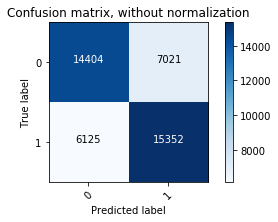

In [109]:
print('MODEL EVALUATION FOR NAIVE BAYES (AUC) WITH COUNT VECTORIZER')

best_min_df = best_params_NB_auc_count['min_df']
best_max_df = best_params_NB_auc_count['max_df']
best_alpha = best_params_NB_auc_count['alpha']
best_ngram = best_params_NB_auc_count['ngram']

vectorizer = CountVectorizer(min_df=best_min_df, max_df=best_max_df, stop_words='english', ngram_range=best_ngram)

if hasattr(vectorizer, 'stop_words_'):
    print('Number of terms ignored/excluded from model: {:,}'.format(len(vectorizer.stop_words_)))

X, y, _ = make_xy(tweets_all_sub, vectorizer)

freq_words(10, vectorizer, X, True)
freq_words(10, vectorizer, X, False)

Xtrain = X[mask]
ytrain = y[mask]
Xtest = X[~mask]
ytest = y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(Xtrain, ytrain)

predictive_words(10, vectorizer, clf, Xtest)

model_eval(clf, Xtrain, Xtest, ytrain, ytest)

MODEL EVALUATION FOR NAIVE BAYES (AUC) WITH TF-IDF VECTORIZER
Most frequent words

    520.37      today
    530.93        don
    554.62 realdonaldtrump
    556.43     people
    601.50      great
    680.64       good
    693.41       like
    720.55       love
    731.97        day
    898.18       just

Total # of words in vocabulary: 21,106
Least frequent words

      0.50        når
      0.50       sirf
      0.52       deze
      0.52         ti
      0.54   momentos
      0.54      leuke
      0.54        tof
      0.55       keer
      0.55        naa
      0.55       tapa

Total # of words in vocabulary: 21,106

Most predictive words
	P(sarcasm | word)
       fun       0.80
      yeah       0.78
        oh       0.78
      glad       0.77
       yay       0.77
   shocked       0.76
      sure       0.74
   totally       0.74
      dare       0.73
    sounds       0.73

Least predictive words
	P(sarcasm | word)
       sad       0.33
 happiness       0.33
   finally       0.33

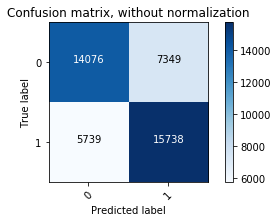

In [111]:
print('MODEL EVALUATION FOR NAIVE BAYES (AUC) WITH TF-IDF VECTORIZER')

best_min_df = best_params_NB_auc_tfidf['min_df']
best_max_df = best_params_NB_auc_tfidf['max_df']
best_alpha = best_params_NB_auc_tfidf['alpha']
best_ngram = best_params_NB_auc_tfidf['ngram']

vectorizer = TfidfVectorizer(min_df=best_min_df, max_df=best_max_df, stop_words='english', ngram_range=best_ngram)

if hasattr(vectorizer, 'stop_words_'):
    print('Number of terms ignored/excluded from model: {:,}'.format(len(vectorizer.stop_words_)))

X, y, _ = make_xy(tweets_all_sub, vectorizer)

freq_words(10, vectorizer, X, True)
freq_words(10, vectorizer, X, False)

Xtrain = X[mask]
ytrain = y[mask]
Xtest = X[~mask]
ytest = y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(Xtrain, ytrain)

predictive_words(10, vectorizer, clf, Xtest)

model_eval(clf, Xtrain, Xtest, ytrain, ytest)

MODEL EVALUATION FOR LOG LIKELIHOOD MODEL
Most frequent words

     2,097       know
     2,217 realdonaldtrump
     2,239      great
     2,269        don
     2,452     people
     2,711       good
     2,743        day
     2,808       love
     3,328       like
     4,595       just

Total # of words in vocabulary: 21,106
Least frequent words

         2 kysportsradio
         2     kickin
         2     kidero
         2     kidnap
         2    kidrock
         2 kiinnostaa
         2 killermartinis
         2     kimchi
         2 kimguilfoyle
         2 kindergartners

Total # of words in vocabulary: 21,106

Most predictive words
	P(sarcasm | word)
      glad       0.84
      dare       0.84
   shocked       0.83
      yeah       0.83
       fun       0.81
        oh       0.81
   totally       0.79
       yay       0.79
    classy       0.78
   clearly       0.78

Least predictive words
	P(sarcasm | word)
  pathetic       0.26
       sad       0.26
      beer       0.26
   chi

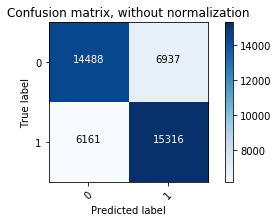

In [51]:
print('MODEL EVALUATION FOR NAIVE BAYES (LOG LIKELIHOOD) WITH COUNT VECTORIZER')

best_min_df = best_params_NB_ll_count['min_df']
best_max_df = best_params_NB_ll_count['max_df']
best_alpha = best_params_NB_ll_count['alpha']
best_ngram = best_params_NB_ll_count['ngram']

vectorizer = CountVectorizer(min_df=best_min_df, max_df=best_max_df, stop_words='english', ngram_range=best_ngram)

if hasattr(vectorizer, 'stop_words_'):
    print('Number of terms ignored/excluded from model: {:,}'.format(len(vectorizer.stop_words_)))

X, y, _ = make_xy(tweets_all_sub, vectorizer)

freq_words(10, vectorizer, X, True)
freq_words(10, vectorizer, X, False)

Xtrain = X[mask]
ytrain = y[mask]
Xtest = X[~mask]
ytest = y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(Xtrain, ytrain)

predictive_words(10, vectorizer, clf, Xtest)

model_eval(clf, Xtrain, Xtest, ytrain, ytest)

MODEL EVALUATION FOR NAIVE BAYES (LOG LIKELIHOOD) WITH TF-IDF VECTORIZER
Most frequent words

    520.37      today
    530.93        don
    554.62 realdonaldtrump
    556.43     people
    601.50      great
    680.64       good
    693.41       like
    720.55       love
    731.97        day
    898.18       just

Total # of words in vocabulary: 21,106
Least frequent words

      0.50        når
      0.50       sirf
      0.52       deze
      0.52         ti
      0.54   momentos
      0.54      leuke
      0.54        tof
      0.55       keer
      0.55        naa
      0.55       tapa

Total # of words in vocabulary: 21,106

Most predictive words
	P(sarcasm | word)
      dare       0.93
   shocked       0.93
   shocker       0.90
  shocking       0.90
       gee       0.89
    classy       0.87
     tebow       0.86
       fun       0.85
      glad       0.85
profootballtalk       0.85

Least predictive words
	P(sarcasm | word)
      bday       0.15
       ate       0.15
     

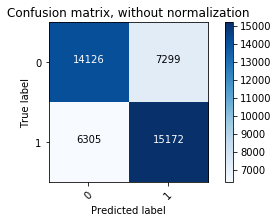

In [114]:
print('MODEL EVALUATION FOR NAIVE BAYES (LOG LIKELIHOOD) WITH TF-IDF VECTORIZER')

best_min_df = best_params_NB_ll_tfidf['min_df']
best_max_df = best_params_NB_ll_tfidf['max_df']
best_alpha = best_params_NB_ll_tfidf['alpha']
best_ngram = best_params_NB_ll_tfidf['ngram']

vectorizer = TfidfVectorizer(min_df=best_min_df, max_df=best_max_df, stop_words='english', ngram_range=best_ngram)

if hasattr(vectorizer, 'stop_words_'):
    print('Number of terms ignored/excluded from model: {:,}'.format(len(vectorizer.stop_words_)))

X, y, _ = make_xy(tweets_all_sub, vectorizer)

freq_words(10, vectorizer, X, True)
freq_words(10, vectorizer, X, False)

Xtrain = X[mask]
ytrain = y[mask]
Xtest = X[~mask]
ytest = y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(Xtrain, ytrain)

predictive_words(10, vectorizer, clf, Xtest)

model_eval(clf, Xtrain, Xtest, ytrain, ytest)

### Dimensionality reduction using truncated SVD (aka LSA)

In [181]:
def create_scatter(graph_df, x_col, y_col, grp_col, num_grps):

    import seaborn as sns
    
    g = sns.lmplot(x=x_col, y=y_col, data=graph_df,
                   fit_reg=False, 
                   palette = 'BrBG',
                   hue=grp_col,
                   size = 5,
                   aspect = 1.5)

    g = (g._legend.set_title('Label'))

    plt.title('SVD Components\n')

In [192]:
# note: trying TruncatedSVD because of message that PCA does not support sparse input

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

n_comp = 4

best_min_df = best_params_NB_auc_count['min_df']
best_max_df = best_params_NB_auc_count['max_df']
best_alpha = best_params_NB_auc_count['alpha']
best_ngram = best_params_NB_auc_count['ngram']

vectorizer = CountVectorizer(min_df=best_min_df, max_df=best_max_df, stop_words='english', ngram_range=best_ngram)

Xthis, ythis, _ = make_xy(tweets_all_sub, vectorizer)

Xtestthis = Xthis[mask]
ytestthis = ythis[mask]
Xtrainthis = Xthis[~mask]
ytrainthis = ythis[~mask]

best_score = -np.inf

for n_comp in range(2,10):
    
    # create new dataframe to store SVD results
    svd_df = tweets_all_sub[mask]

    # identify two SVD components and add to dataframe
    svd = TruncatedSVD(n_components=n_comp)
    
    svd.fit(Xtestthis) # should this be training or test set?
    components = svd.transform(Xtestthis) # should this be training or test set?

    # does the below only work for 2 components?
    # (should I have n_component number of X's?)
    x = components[:,0]
    y = components[:,1]

    svd_df['x'] = x 
    svd_df['y'] = y

    svd_df = svd_df[['user_tweet_id', 'sarcasm', 'x', 'y']]

    exp_var_rat = svd.explained_variance_ratio_.sum()
    
    print('When n_components = {}, the explained variance ratio = {:.3f}'.format(n_comp, exp_var_rat))
    
    if exp_var_rat > best_score:
        best_n_comp = n_comp
        best_score = exp_var_rat

print('\nHighest total explained variance ratio ({:.3f}) was for {} components'.format(best_score, best_n_comp))

/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


When n_components = 2, the explained variance ratio = 0.018
When n_components = 3, the explained variance ratio = 0.026
When n_components = 4, the explained variance ratio = 0.034
When n_components = 5, the explained variance ratio = 0.041
When n_components = 6, the explained variance ratio = 0.048
When n_components = 7, the explained variance ratio = 0.054
When n_components = 8, the explained variance ratio = 0.059
When n_components = 9, the explained variance ratio = 0.065

Highest total explained variance ratio (0.065) was for 9 components


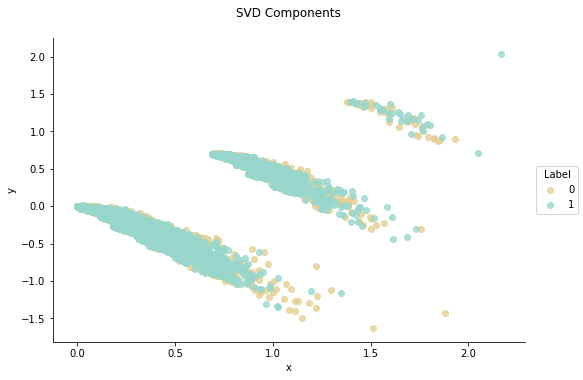

In [173]:
# Plot SVD components
create_scatter(tsvd_df, 'x', 'y', 'sarcasm', 2)

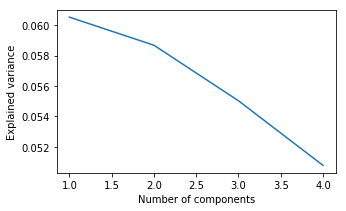

In [174]:
# Plot explained variance for each number of components
plt.plot(range(1,tsvd.components_.shape[0]+1), tsvd.explained_variance_)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()